In [39]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mude_tools import magicplotter
%matplotlib widget

## Introduction

As the previous notebook shows, the least squares approach can lead to severe over-fitting if complex models are trained on small datasets. Our strategy of limiting the number of basis functions a priori to counter the over-fitting puts us at risk of missing critical trends in the data. Another way to control the model's flexibility is by introducing a regularization term. This additional term essentially puts a penalty on the weights and prevents them from taking too large values unless supported by the data. The concept of regularized least squares will be demonstrated on the usual sine function.

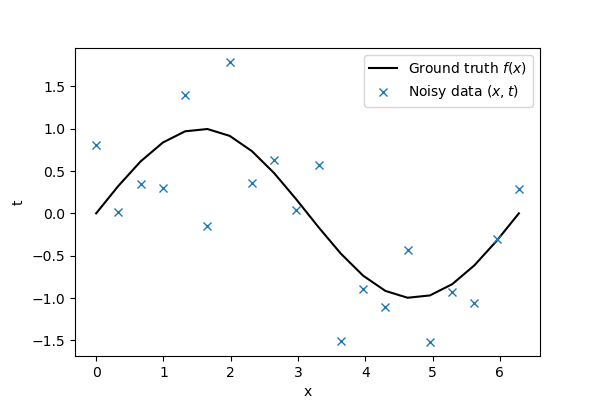

In [40]:
np.random.seed(1)

# The true function relating t to x
def f_truth(x, freq=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.5, N=20, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Get the observed data
# x, t = f_data(xmin = -1, xmax = 1)
x, t = f_data()

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x, f_truth(x), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

## Regularized least squares

We extend the data-dependent error $E_D(\bf{w})$ with the regularization term $E_W(\bf{w})$:

$$
E (\mathbf{w}) = E_D (\mathbf{w}) + \lambda E_W (\mathbf{w})
$$

with regularization parameter $\lambda$ that controls the relative importance of two terms comprising the error function. A common choice for the regularizer is the sum-of-squares:

$$
E_W(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T \mathbf{w}.
$$

The resulting model is known as L2 regularization, Ridge regression, or weight decay. The total error therefore becomes

$$
E (\mathbf{w}) = \frac{1}{2} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi} (x_n) \right)^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}.
$$

<!-- Taking its gradient gives

$$
\nabla_{\mathbf{w}} E_{\mathcal{D}} = \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x}_n \big) \mathbf{x}_n
$$ -->

A useful property of the L2 regularization is that the error functions is still a quadratic function, allowing for a closed form solution for its minimizer. Setting the gradient of the regularized error function with respect to $\mathbf{w}$ to $0$ gives

$$
\bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.
$$

<!-- Keeping in mind that $\boldsymbol{\Phi}^T \boldsymbol{\Phi}$ is a positive semi-definite matrix, the eigenvalues of the inverse of $\boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I}$ will shrink with an inceasing $\lambda$, therefore pulling the weights towards $0$ compared to the unregularized solution. -->

## Determining the regularization parameter

The problem of controlling the model complexity has been shifted from choosing a suitable set of basis functions to determining the regularization parameter $\lambda$. Optimizing for both $\mathbf{w}$ and $\lambda$ over the training dataset will favor the models' flexibility, leading to the trivial solution $\lambda = 0$ and, therefore, to the unregularized least squares problem. A better approach is partitioning the data into training and validation sets. The training set is used to determine the parameters $\mathbf{w}$, and the validation set to optimize the model complexity. Let's define a few things we need for the analysis: the polynomial basis functions and an adapted predict function we can pass to our magicplotter utility. Further, we need to normalize the data. This step is at least recommended, often even necessary, for most machine learning techniques. A non-normalized dataset always leads to a numerically more challenging optimization problem. For our case, with the polynomial basis functions, data normalization is crucial due to the global nature of the features. We use the `StandardScaler` class from the `sklearn.preprossesing` library for this purpose. The normalized dataset $\hat{\mathcal{D}} = ( \hat{x}, \hat{t} )$ is obtained by subtracting the mean $\mu$, and dividing by the standard deviation $\sigma$ of the data:

$$
\hat{x} = \frac{x - \mu_x}{\sigma_x}  \quad \mathrm{and} \quad \hat{t} = \frac{t - \mu_t}{\sigma_t}.
$$

Take a look at the unnormalized and normalized data. Note that the normalization of the target $t$ has a marginal effect, as the sine function is centered at 0 and almost shows a standard deviation of 1. Assuming normally distributed data, the bounding box dimensions correspond to intervals of two standard deviations for inputs and labels,  each containing 95% of the datapoints.

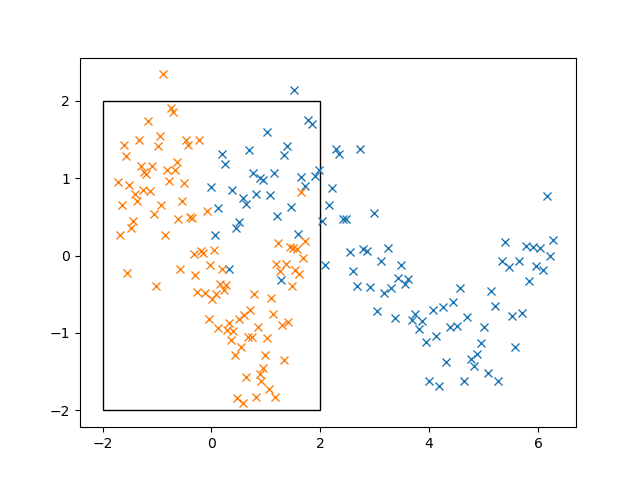

In [59]:
# generate data, instantiate scaler, and fit tranform
np.random.seed(0)
x, t = f_data(N=100)
xscaler, tscaler = StandardScaler(), StandardScaler()
x_norm, t_norm = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])

# plot
fig, ax = plt.subplots()
ax.plot(x,t,'x')
ax.plot(x_norm,t_norm,'x')

# Create a Rectangle patch
rect = patches.Rectangle((-2, -2), 4, 4, linewidth=1., edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [4]:
# Here is a function for the polynomial basis functions:
def PolynomialBasis(x, degree, **kwargs):  #**kwargs):
    """
    A function that computes polynomial basis functions.
    
    Arguments:
    x       -  The datapoints
    degree  -  The degree of the polynomial
    """
    return np.array([x ** i for i in range(degree + 1)]).transpose()

In [5]:
# Define a function that makes a prediction at the given locations, based on the given (x,t) data
def predict(x, t, x_pred, basis, lam=None, **kwargs):
    
    # reshape if necessary for scalers
    x = x[:,None] if len(x.shape)==1 else x
    t = t[:,None] if len(t.shape)==1 else t
    x_pred = x_pred[:,None] if len(x_pred.shape)==1 else x_pred
    
    # normalize data
    xscaler, tscaler = StandardScaler(), StandardScaler()
    x_sc, t_sc = xscaler.fit_transform(x), tscaler.fit_transform(t)
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x_sc.reshape(-1), **kwargs)
    t_sc = t_sc.reshape(-1)
    x_pred = xscaler.transform(x_pred).reshape(-1)
    
    # Get identity matrix, set first entry to 0 to neglect bias in regularizaiton
    I = np.identity(Phi.shape[1])
    I[0,0] = 0.0
    
    # Get the coefficient vector
    if lam is None:
        w = np.linalg.solve( Phi.T @ Phi , Phi.T @ t_sc )
    else:
        w = np.linalg.solve( Phi.T @ Phi + lam * I, Phi.T @ t_sc )
    
    # Make a prediction in the prediction locations
    Phi_pred = basis(x_pred, **kwargs)
    t_pred = Phi_pred @ w
    
    # Return the predicted values
    return tscaler.inverse_transform(t_pred[:,None]).reshape(-1)

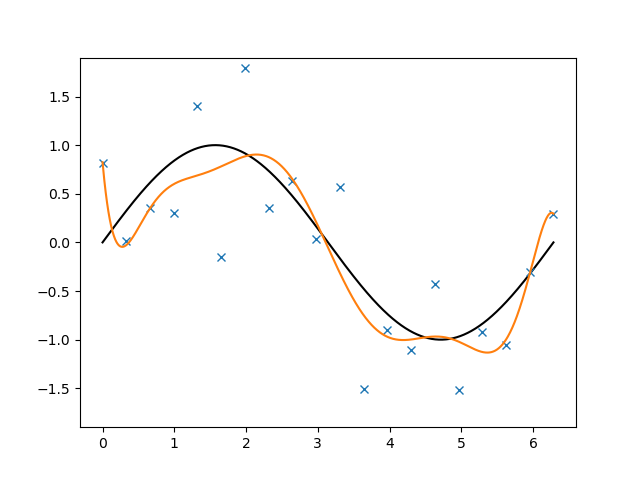

In [6]:
# Let's try out our ridge regression model
np.random.seed(1)
x, t = f_data()
x_plot = np.linspace(0, 2*np.pi, 1000)[:,None]
t_plot = predict(x, t, x_plot, PolynomialBasis, degree=9, lam=1e-12)

# plot the results
fig, ax = plt.subplots()
ax.plot(x_plot, f_truth(x_plot), 'k-', label=r'Ground truth $f(x)$')
ax.plot(x, t, 'x')
ax.plot(x_plot, t_plot)
ax.set_ylim(-1.9,1.9)
plt.show()

You can play around with the polynomial degree and the regularization parameter. Try to answer the following questions:

- What happens for a low degree of polynomial features, and what happens for a high degree?

- How does this affect the value of $\lambda$ that yields the (visually) best fit?

- How does a larger dataset affect the optimal regularization parameter $\bar{\lambda}$?


The pressing question is, of course: how do we determine the optimal value for $\lambda$, meaning the degree of regularization that yields the best predictive capability?

Best fit for lambda = 5.454956e-01  with MSE = 0.158826


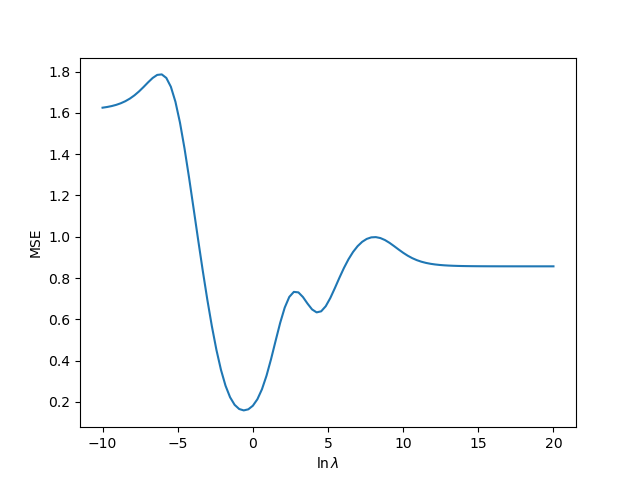

In [7]:
# set seed and generate data
np.random.seed(0)
x, t = f_data(N=30)

# partition dataset into training and validation set
Ntrain = int(0.7*len(x))
x_train, x_val, t_train, t_val = train_test_split(x, t, train_size=Ntrain)

# set up some vectores and params for the training
lams    = np.linspace(-10,20,100)
mse_val = np.zeros_like(lams)
x_plot  = np.linspace(0, 2*np.pi, 1000)[:,None]
degree  = 9

# loop over all lambdas 
for i, lam in enumerate(lams):
    t_pred = predict(x_train, t_train, x_val, PolynomialBasis, degree=degree, lam=np.exp(lam))
    mse_val[i] = sum((t_val - t_pred)**2) / len(x_val)

# find lambda with minimum mse
loc = np.argmin(mse_val)
lam_min = lams[loc]
mse_min = mse_val[loc]
print("Best fit for lambda = {:e}  with MSE = {:4f}".format(np.exp(lam_min), mse_min))
    
# plot mse over ln(lambda)
fig, ax = plt.subplots()
ax.plot(lams, mse_val)
ax.set_xlabel(r'$\mathrm{ln}\,\lambda$')
ax.set_ylabel(r'MSE')
plt.show()

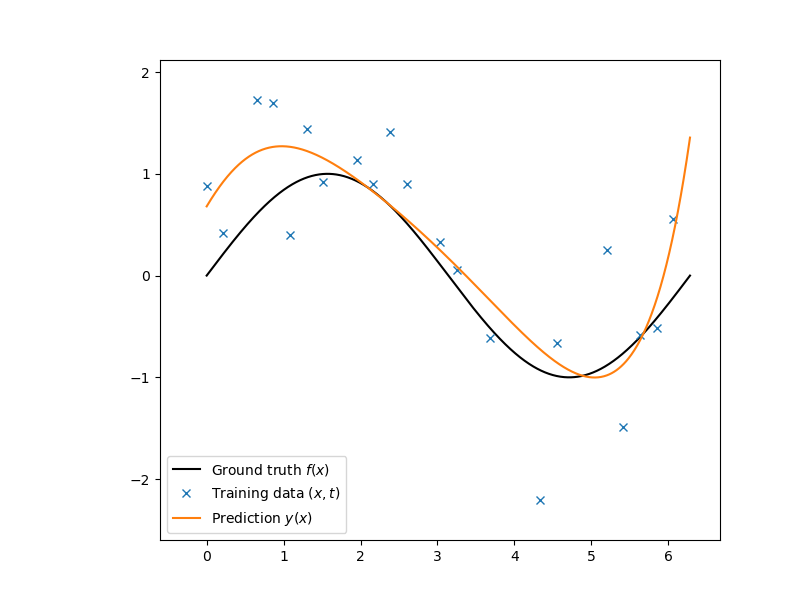

In [8]:
# Let's take a look at our regularized solution
plot = magicplotter(f_data, f_truth, predict, x_plot, x_train, t_train,
                    basis=PolynomialBasis, degree=degree, lam=np.exp(lam_min),
                    pred_label='Prediction $y(x)$', seed=0)

That looks much better than the solution of the unregularized problem, which you can obtain by removing $\lambda$ from arguments when calling the `predict` function. Luckily, this problem has a unique solution $\bar{\lambda}$. Can you explain why the error first decreases but keeps growing again at some point? Do you always expect this non-monotonic characteristic when looking at the error as a function of the regularization parameter?

## Stochastic Gradient Descent (SGD)

For now, we used the same dataset at once. In some situations, it might be beneficial or necessary to look at only a part of the dataset, e.g., when

- $N$ is too large and computing $( \boldsymbol{\Phi}^T \boldsymbol{\Phi} )^{-1}$ becomes prohibitively expensive
- the model is nonlinear in $\mathbf{w}$, and $\mathbf{w}_{ML}$ does not have a closed-form solution
- the dataset is arriving sequentially (e.g., in real-time from a sensor)

Instead of solving for $\mathbf{w}$ directly, we could employ an iterative optimization strategy. Let's first take a look at the data part of the error function:

$$
\frac{1}{2N} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi} (x_n) \right)^2 \quad \mathrm{with \, gradient} \quad \nabla E_{\mathcal{D}} = - \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \boldsymbol{\phi}_n \big) \boldsymbol{\phi}_n
$$

With a standard gradient descent algorithm, the update rule for the weights is given by

$$
\mathbf{w}^{(\tau + 1)} = \mathbf{w}^{(\tau)} - \eta \nabla E_D
$$

with a fixed *learning rate* $\eta$. The costs for the gradient computations are independent of the dataset size $N$, when only considering subset $\mathcal{B}$ of our dataset with $N_{\mathcal{B}}$ data points. If we pick a random subset $B$ for each iteration of the optimization scheme, we have derived the *stochastic gradient descent* algorithm. Together with its numerous variants, this algorithm forms the backbone of many machine learning techniques. Most deep-learning libraries, such as `TensorFlow` or `PyTorch` offer implementations of these algorithms.

In [9]:
# This function returns the gradient of the cost function
def get_gradient(x, t, w, basis, **kwargs):
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x.reshape(-1), **kwargs)
    t = t.reshape(-1)
    
    return - ( t - w @ Phi.T ) @ Phi / len(t)

In [27]:
# This function returns the gradient of the cost function
def get_reg_gradient(x, t, w, basis, lam=0., **kwargs):
    
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x.reshape(-1), **kwargs)
    t = t.reshape(-1)
    
    return - ( t - w @ Phi.T ) @ Phi / len(t) + lam * w

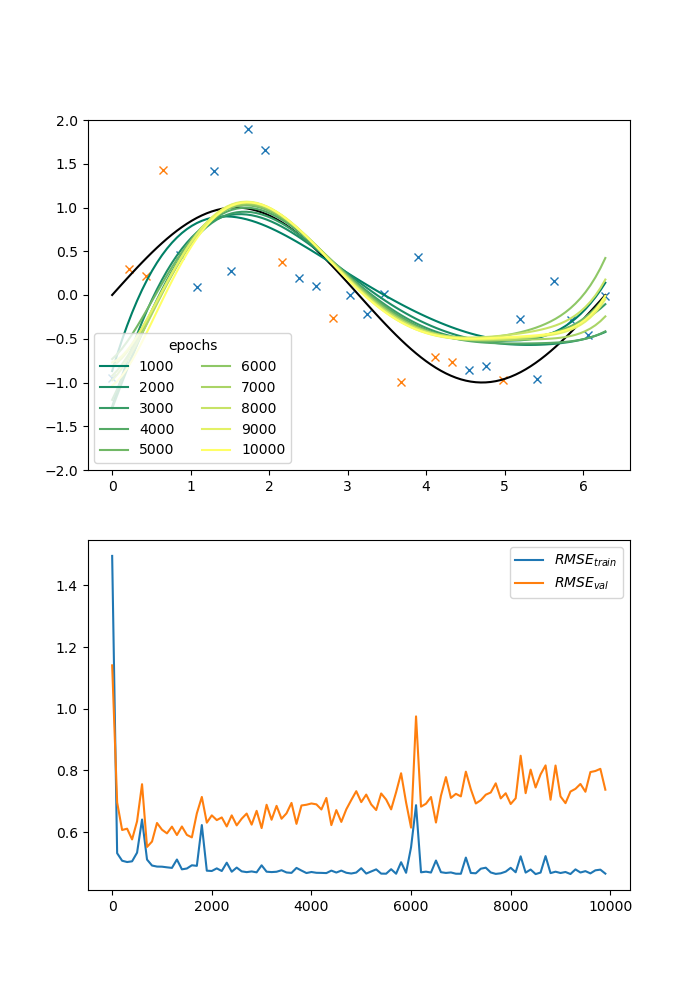

In [36]:
# set parameters
np.random.seed(5)
N = 30
N_train = int(0.7*N)
degree = 6 
w = np.random.rand(degree+1)
eta = 0.01
epochs = 10000
epoch_plot = max(int(epochs/10),1)
N_batch = 5

# get colormap
rgb = cm.get_cmap('summer')(np.linspace(0,1,10))[:, :3]

# generate, scale, and partition data
x, t = f_data(N=N)
x_plot = np.linspace(0,2*np.pi,100)
xscaler, tscaler = StandardScaler(), StandardScaler()
x_sc, t_sc = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])
x_train, x_val, t_train, t_val = train_test_split(x_sc, t_sc, train_size=N_train)
x_train, x_val, t_train, t_val = x_train.reshape(-1), x_val.reshape(-1), t_train.reshape(-1), t_val.reshape(-1)

# get features
Phi_plot  = PolynomialBasis(xscaler.transform(x_plot[:,None]).reshape(-1), degree=degree)
Phi_train = PolynomialBasis(x_train, degree=degree)
Phi_val   = PolynomialBasis(x_val, degree=degree)

# create figure
fig, ax = plt.subplots(2, 1, figsize = (7,10))
ax[0].plot(xscaler.inverse_transform(x_train[:,None]), tscaler.inverse_transform(t_train[:,None]), 'x')
ax[0].plot(xscaler.inverse_transform(x_val[:,None]), tscaler.inverse_transform(t_val[:,None]), 'x')
ax[0].plot(x_plot, f_truth(x_plot), 'k-')
ax[0].set_ylim(-2,2)

# init mse
rmse_train = np.zeros(epochs)
rmse_val = np.zeros(epochs)

# loop over epochs
for i in range(epochs):
    perm = np.random.permutation(N_train)
    
    # loop over batches
    for j in range(int(N_train/N_batch)):
        x_batch = x_train[perm[j*N_batch:(j+1)*N_batch]]
        t_batch = t_train[perm[j*N_batch:(j+1)*N_batch]]
        dEdw    = get_gradient(x_batch, t_batch, w, PolynomialBasis, degree=degree)
        w       = w - eta * dEdw
        
    # compute mse
    t_pred_train = w @ Phi_train.T
    t_pred_val   = w @ Phi_val.T
    
    rmse_train[i] = np.sqrt(sum((tscaler.inverse_transform(t_train[:,None])
                                - tscaler.inverse_transform(t_pred_train[:,None]))**2) / len(t_train))
    rmse_val[i]   = np.sqrt(sum((tscaler.inverse_transform(t_val[:,None])
                                - tscaler.inverse_transform(t_pred_val[:,None]))**2) / len(t_val))
    
    # plot some of the iterations to see progression of solution
    if ((i+1) % epoch_plot==0):
        t_plot = w @ Phi_plot.T
        ax[0].plot(x_plot, tscaler.inverse_transform(t_plot[:,None]).reshape(-1),
                   color=rgb[int(i/epoch_plot),:], label=r'{}'.format(i+1))

# plot rmse
ax[1].plot(np.arange(0,epochs,int(epochs/100)), rmse_train[::int(epochs/100)], label=r'$RMSE_{train}$')
ax[1].plot(np.arange(0,epochs,int(epochs/100)), rmse_val[::int(epochs/100)], label=r'$RMSE_{val}$')
ax[1].legend()
ax[0].legend(loc='lower left', ncol=2)
ax[0].get_legend().set_title(r'epochs')
plt.show()

You can see in the top figure that our predictions seem to converge towards a particular shape. The remaining discrepancy between our final model and the true function $f$ is due to our model bias and the dataset we drew. What happens if you increase the polynomial degree of our basis functions? Can you explain why we do not approach the target function?

You can see that our training error increases at some point, indicating that overfitting might occur. SGD with minibatches already has a slight regularizing effect. Other remedies include the regularization technique discussed previously or collecting more data. Try to guess how the RMSE for the training and validation set will behave for larger datasets.

Finally, it should be noted that the step size of the SGD must be chosen carefully. Try out for yourself what happens when you choose very small or large stepsizes. Even though this optimization problem is well-defined and has a global minimum, SGD is not guaranteed to converge to it. Most variants of SGD feature some form of automatic stepsize control. One usually starts with a larger stepsize to approach the minimum quickly. After that, the stepsize is reduced continuously to find the exact location of the extremum.